In [ ]:
# !pip install orbit-ml
# !pip install orbit
# !pip install prophet
# !pip install sktime[all_extras]

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns #для матрицы корреляций

import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sma

import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)

In [ ]:
df = pd.read_csv('airline_portcountry.csv')
df.dtypes

Month                    object
Airline                  object
Port_Country             object
Passengers_In           float64
Freight_In_(tonnes)     float64
Mail_In_(tonnes)        float64
Passengers_Out          float64
Freight_Out_(tonnes)    float64
Mail_Out_(tonnes)       float64
Year                      int64
Month_num                 int64
dtype: object

In [ ]:
df.head(10)

,Month,Airline,Port_Country,Passengers_In,Freight_In_(tonnes),Mail_In_(tonnes),Passengers_Out,Freight_Out_(tonnes),Mail_Out_(tonnes),Year,Month_num
0,Jan-85,Air Caledonie,New Caledonia,725.00,0.37,0.00,474.00,0.17,0.00,1985,1
1,Jan-85,Air China,China,1311.00,9.16,0.00,1232.00,2.59,0.00,1985,1
2,Jan-85,Air India,India,1423.00,44.82,0.00,970.00,6.71,0.00,1985,1
3,Jan-85,Air India,Singapore,501.00,10.58,0.00,306.00,124.97,0.00,1985,1
4,Jan-85,Air Nauru,Nauru,161.00,0.21,0.00,96.00,24.00,0.00,1985,1
5,Jan-85,Air New Zealand,New Zealand,24588.00,873.07,0.37,20692.00,348.74,0.12,1985,1
6,Jan-85,Air Niugini,Papua New Guinea,2954.00,20.04,0.00,2906.00,69.05,0.00,1985,1
7,Jan-85,Air Pacific,Fiji,3350.00,26.26,0.00,2470.00,100.64,0.00,1985,1
8,Jan-85,Air Pacific,Solomon Islands,574.00,3.23,0.00,578.00,12.32,0.00,1985,1
9,Jan-85,Air Pacific,Vanuatu,280.00,0.36,0.00,205.00,2.73,0.00,1985,1


In [ ]:
df.columns

Index(['Month', 'Airline', 'Port_Country', 'Passengers_In',
       'Freight_In_(tonnes)', 'Mail_In_(tonnes)', 'Passengers_Out',
       'Freight_Out_(tonnes)', 'Mail_Out_(tonnes)', 'Year', 'Month_num'],
      dtype='object')

In [ ]:
df.columns = ['Month', 'Airline', 'Country', 'Passengers_In',
       'Freight_In', 'Mail_In', 'Passengers_Out',
       'Freight_Out', 'Mail_Out', 'Year', 'Month_Num']
df.head()

,Month,Airline,Country,Passengers_In,Freight_In,Mail_In,Passengers_Out,Freight_Out,Mail_Out,Year,Month_Num
0,Jan-85,Air Caledonie,New Caledonia,725.00,0.37,0.00,474.00,0.17,0.00,1985,1
1,Jan-85,Air China,China,1311.00,9.16,0.00,1232.00,2.59,0.00,1985,1
2,Jan-85,Air India,India,1423.00,44.82,0.00,970.00,6.71,0.00,1985,1
3,Jan-85,Air India,Singapore,501.00,10.58,0.00,306.00,124.97,0.00,1985,1
4,Jan-85,Air Nauru,Nauru,161.00,0.21,0.00,96.00,24.00,0.00,1985,1


Создадим новую переменную с датой в формате datetime64:

In [ ]:

df['Date'] =  pd.to_datetime(df.Year.astype(str) + '-' + df.Month_Num.astype(str) + '-01')


Изучим типы переменных в нашем датасете:

In [ ]:
df.dtypes

Month                     object
Airline                   object
Country                   object
Passengers_In            float64
Freight_In               float64
Mail_In                  float64
Passengers_Out           float64
Freight_Out              float64
Mail_Out                 float64
Year                       int64
Month_Num                  int64
Date              datetime64[ns]
dtype: object

Первичный анализ 

Описательная статистика всех переменных:

In [ ]:

df.describe()

,Passengers_In,Freight_In,Mail_In,Passengers_Out,Freight_Out,Mail_Out,Year,Month_Num
count,43823.00,43838.00,43838.00,43824.00,43848.00,43848.00,43856.00,43856.00
mean,8090.72,299.18,14.35,7980.96,270.44,8.46,2003.47,6.49
std,15896.38,674.14,40.40,15652.57,614.58,28.79,10.39,3.46
min,0.00,0.00,0.00,0.00,0.00,0.00,1985.00,1.00
25%,358.00,2.03,0.00,378.00,7.97,0.00,1995.00,3.00
50%,2291.00,59.49,0.02,2250.50,56.23,0.00,2004.00,6.00
75%,7530.00,278.71,5.08,7331.50,226.43,2.60,2012.00,10.00
max,171730.00,8512.98,458.98,171339.00,9017.62,492.98,2021.00,12.00


In [ ]:
# Посчитаем общее количество аэропортов и стран

n1 = df['Airline'].nunique()
n2 = df['Country'].nunique()
print(f'Количество аэропортов = {n1}, Количество стран = {n2}')


Количество аэропортов = 139, Количество стран = 74


In [ ]:
# Поиск и удаление пропусков

df.head()
print(df.isna().sum())

# Имеет пропуски в нескольких переменных:

Month              0
Airline            0
Country            0
Passengers_In     33
Freight_In        18
Mail_In           18
Passengers_Out    32
Freight_Out        8
Mail_Out           8
Year               0
Month_Num          0
Date               0
dtype: int64


In [ ]:
#Удалим пропуски. 33 пропуска из 43856 значений - это менее 0,1%   (0,075%)
df = df[df['Passengers_In'].notna()]
print(df.isna().sum())


Month             0
Airline           0
Country           0
Passengers_In     0
Freight_In        0
Mail_In           0
Passengers_Out    0
Freight_Out       0
Mail_Out          0
Year              0
Month_Num         0
Date              0
dtype: int64


Построим корреляционную матрицу


In [ ]:
df.corr()

,Passengers_In,Freight_In,Mail_In,Passengers_Out,Freight_Out,Mail_Out,Year,Month_Num
Passengers_In,1.00,0.79,0.64,0.99,0.79,0.37,0.20,-0.00
Freight_In,0.79,1.00,0.62,0.79,0.85,0.28,0.16,0.03
Mail_In,0.64,0.62,1.00,0.64,0.57,0.37,0.14,0.03
Passengers_Out,0.99,0.79,0.64,1.00,0.79,0.38,0.20,0.01
Freight_Out,0.79,0.85,0.57,0.79,1.00,0.25,0.12,0.02
Mail_Out,0.37,0.28,0.37,0.38,0.25,1.00,0.04,0.04
Year,0.20,0.16,0.14,0.20,0.12,0.04,1.00,-0.01
Month_Num,-0.00,0.03,0.03,0.01,0.02,0.04,-0.01,1.00


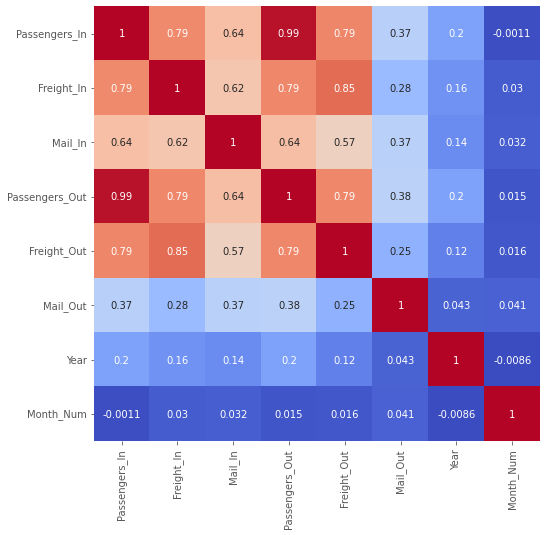

In [ ]:
# Визуализируем корреляционную матрицу

plt.rcParams['figure.figsize'] = (8, 8)
sns.heatmap(df.corr(), annot = True, fmt='.2g', cbar=False,cmap= 'coolwarm' )


Отметим наибольшие корреляции: 
* 0,99 Passengers_In	и Passengers_Out
* 0,85 Freight_In       и Freight_Out
* 0,79 Passengers_In	и Freight_In
* 0,79 Passengers_In	и Freight_Out
* 0,79 Passengers_Out	и Freight_In
* 0,79 Passengers_Out	и Freight_In

In [ ]:
# Посчитаем Топ 5 аэропортов по количеству вылетающих пассажиров
# A = df.groupby(['Year', 'Month_Num', 'Airline'])[['Passengers_In',	'Freight_In',	'Mail_In',	'Passengers_Out',	'Freight_Out',	'Mail_Out']].sum()
# A1 = df.groupby(['Year', 'Month', 'Airline'])[['Passengers_In',	'Freight_In',	'Mail_In',	'Passengers_Out',	'Freight_Out',	'Mail_Out']].sum()
df.groupby(['Airline'])[['Passengers_In',	'Freight_In',	'Mail_In',	'Passengers_Out',	'Freight_Out',	'Mail_Out']].sum().sort_values('Passengers_In', ascending = False).head(5)


,Passengers_In,Freight_In,Mail_In,Passengers_Out,Freight_Out,Mail_Out
Airline,,,,,,
Qantas Airways,88433829.00,2815791.29,155332.66,86988624.00,2480693.05,287811.06
Singapore Airlines,31776797.00,1817584.69,66973.03,30990740.00,1812181.71,5335.91
Air New Zealand,30143354.00,861725.31,52764.63,29947807.00,806218.31,6596.34
Emirates,20525474.00,828045.01,21655.84,19763783.00,799263.53,7305.73
Jetstar,17737577.00,175657.29,4826.30,17712481.00,64439.55,3745.01


In [ ]:
# Топ 5 стран по вылетающим пассажирам
df.groupby(['Country'])[['Passengers_In',	'Freight_In',	'Mail_In',	'Passengers_Out',	'Freight_Out',	'Mail_Out']].sum().sort_values('Passengers_In', ascending = False).head(5)

,Passengers_In,Freight_In,Mail_In,Passengers_Out,Freight_Out,Mail_Out
Country,,,,,,
New Zealand,71322138.00,1934988.10,62904.91,71698098.00,2039787.04,70706.10
Singapore,53714241.00,2408309.97,85535.43,51623246.00,2708034.48,39755.61
USA,29814722.00,1971750.11,121598.17,29896071.00,728834.15,61249.83
Indonesia,21535688.00,291612.36,13327.91,21516954.00,209947.65,1873.92
Japan,21261404.00,507023.44,69329.97,21164825.00,682152.70,32293.58


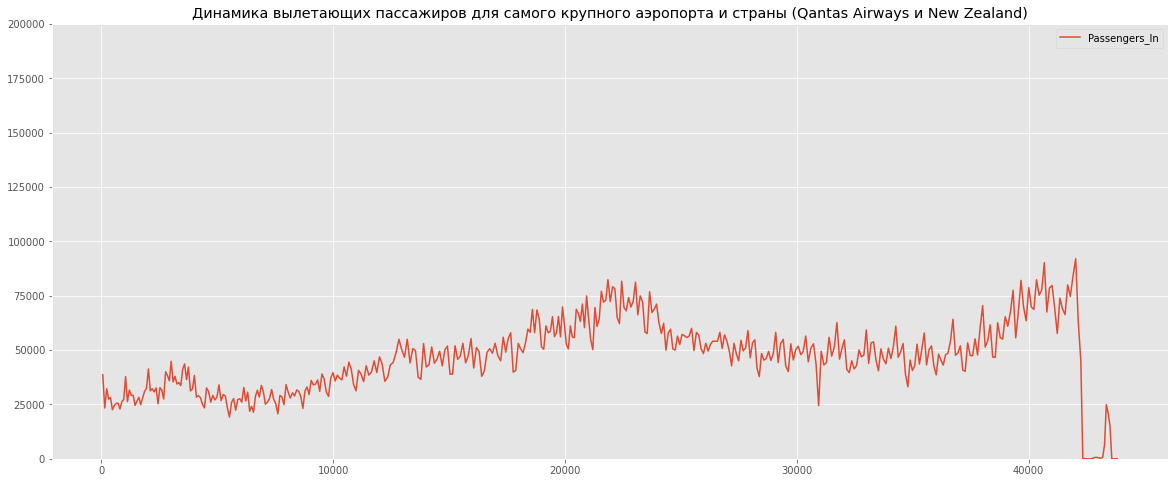

In [ ]:
# Динамика вылетающих пассажиров для самого крупного аэропорта и страны

plt.rcParams['figure.figsize'] = (20, 8)
cond1 = (df['Country'] == 'New Zealand') & (df['Airline'] == 'Qantas Airways')
df[cond1][['Passengers_In']].plot(ylim = (0, 200000), title = 'Динамика вылетающих пассажиров для самого крупного аэропорта и страны (Qantas Airways и New Zealand)' )




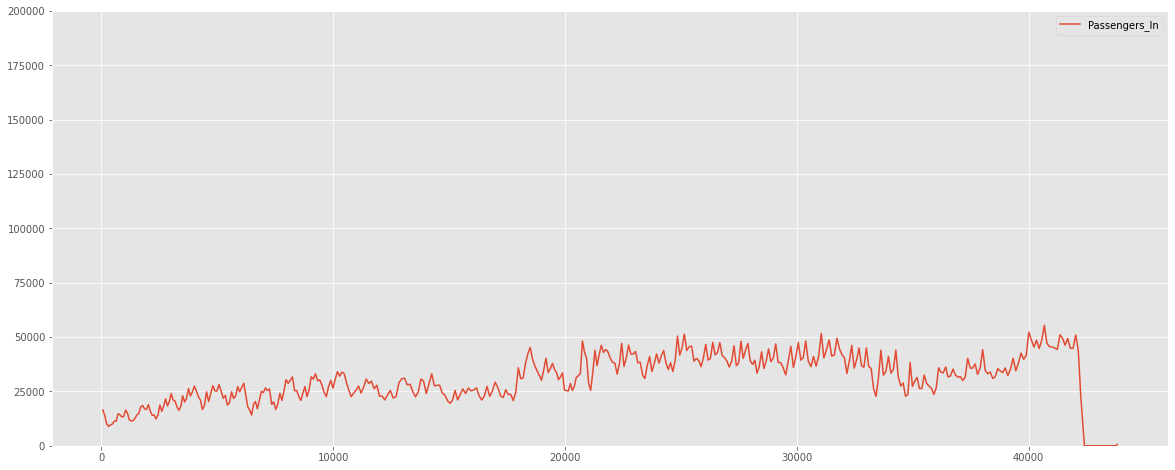

In [ ]:
# Динамика вылетающих пассажиров для самых крупных аэропортов и стран
plt.rcParams['figure.figsize'] = (20, 8)

cond1 = (df['Country'] == 'Singapore') & (df['Airline'] == 'Qantas Airways')
df[cond1][['Passengers_In']].plot(ylim = (0,200000), title = 'Динамика вылетающих пассажиров для Qantas Airways и Singapore' )

Динамика вылетающих пассажиров для самых крупных аэропортов и стран


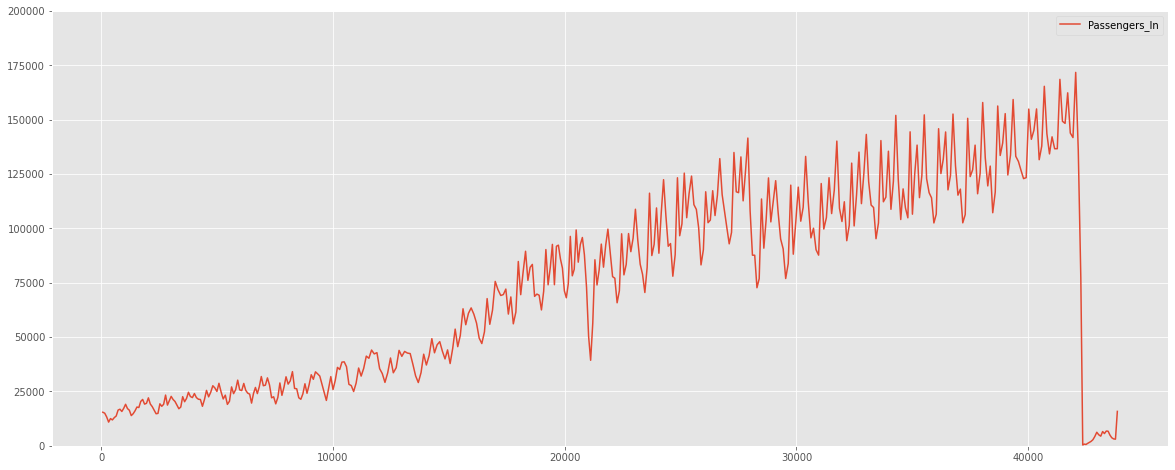

In [ ]:
plt.rcParams['figure.figsize'] = (20, 8)

cond1 = (df['Country'] == 'Singapore') & (df['Airline'] == 'Singapore Airlines')
df[cond1][['Passengers_In']].plot(ylim = (0,200000), title = 'Динамика вылетающих пассажиров для Singapore Airlines и Singapore')

Динамика вылетающих пассажиров для самых крупных аэропортов и стран


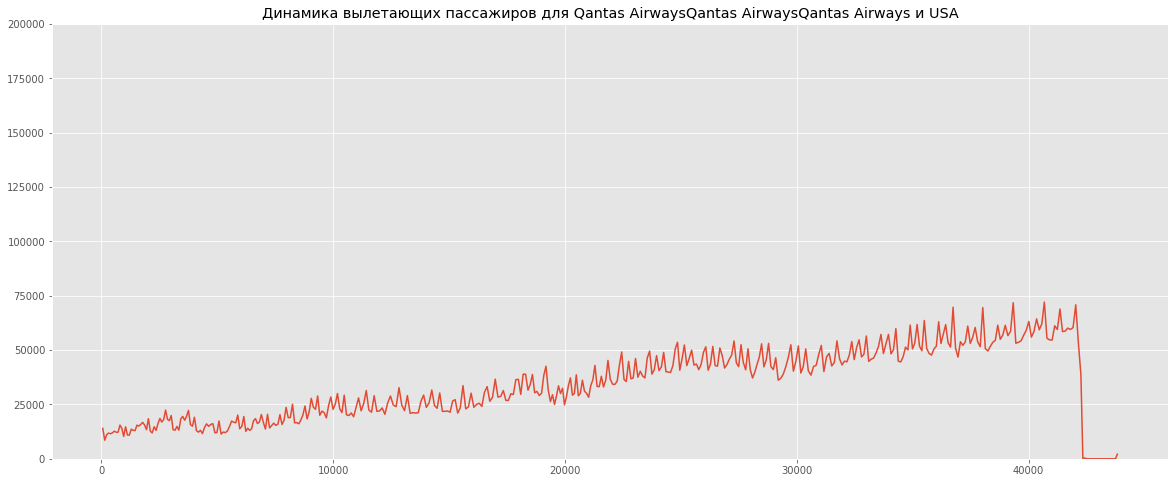

In [ ]:
plt.rcParams['figure.figsize'] = (20, 8)

cond1 = (df['Country'] == 'USA') & (df['Airline'] == 'Qantas Airways')
d2 = df[cond1][['Passengers_In', 'Date']]
d2['Passengers_In'].plot(x = 'Date', ylim = (0, 200000), title = 'Динамика вылетающих пассажиров для Qantas AirwaysQantas AirwaysQantas Airways и USA')



простое прогнозирование средним значением
USA  & Qantas Airway

Отметим, что с определенного момента пассажиропоток обнуляется - это связано с введением карантина
Поэтому анализ имеет смысл делать до этого момента

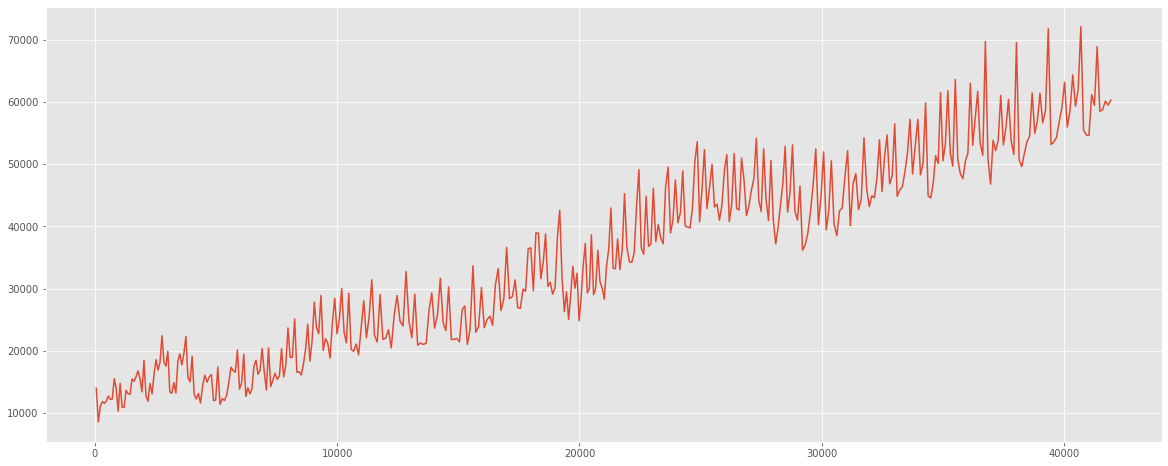

In [ ]:




plt.rcParams['figure.figsize'] = (20, 8)

d2=d2[0:420]

model_mean_pred = d2["Passengers_In"].mean()
d2["Passengers_In_Mean"] = model_mean_pred
d2['Passengers_In'].plot(kind="line", y = ["Passengers_In", "Passengers_In_Mean"])



**Как мерить качество?**

Чтобы обучать регрессионные модели, нужно определиться, как именно измеряется качество предсказаний.   
Будем использовать метрику RMSE (Root Mean Squared Error) - корень среднего квадрата отклонения.

$$RMSE =  \sqrt{ \Sigma (\hat{y} - y)^2/n} $$ , 
где $\hat{y}$ это предсказанное значение y



In [ ]:
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/mse.count())
    return rmse

In [ ]:
model_mean_RMSE = RMSE(d2.Passengers_In_Mean, d2.Passengers_In)
model_mean_RMSE

15492.44829186684

In [ ]:
d2Results = pd.DataFrame(columns = ["Model", "RMSE"])
d2Results.head()

,Model,RMSE


In [ ]:
d2Results.loc[0,"Model"] = "Mean"
d2Results.loc[0,"RMSE"] = model_mean_RMSE
d2Results.head()

,Model,RMSE
0,Mean,15492.45


**Линейная модель**

Построим линейную зависиммость между priceModLog and time.   
Уравнение регрессии строится с помощью метода наимменьших квадратов.

In [ ]:
# Введем индекс
TimeIndex = range(0, 420)
d2["TimeIndex"] = range(0, 420)
d2.head()
d2.tail()

,Passengers_In,Date,Passengers_In_Mean,TimeIndex
41467,58497.00,2019-08-01,34627.86,415
41580,58726.00,2019-09-01,34627.86,416
41693,60117.00,2019-10-01,34627.86,417
41805,59478.00,2019-11-01,34627.86,418
41921,60297.00,2019-12-01,34627.86,419


In [ ]:
model_linear = smf.ols('Passengers_In ~ TimeIndex', data = d2).fit()

In [ ]:
model_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Passengers_In   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     4284.
Date:                Sun, 25 Dec 2022   Prob (F-statistic):          8.49e-222
Time:                        20:12:00   Log-Likelihood:                -4139.9
No. Observations:                 420   AIC:                             8284.
Df Residuals:                     418   BIC:                             8292.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9075.5417    451.056     20.121      0.000    8188.920    9962.163
TimeIndex    121.9681      1.863     65.453      0.000     118.305     125.631
==============================================================================
Omnibus:                       23.245   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.970
Skew:                           0.609   Prob(JB):                     2.29e-06
Kurtosis:                       3.046   Cond. No.                         483.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Выведем параметры нашей линейной модели


In [ ]:
model_linear.params

Intercept   9075.54
TimeIndex    121.97
dtype: float64

In [ ]:
c = model_linear.params[0]
c

9075.541748670963

In [ ]:
m = model_linear.params[1]
m

121.96811530353669

In [ ]:
model_linear_pred = model_linear.predict()


In [ ]:
plt.rcParams['figure.figsize'] = (20, 8)

d2.plot(kind="line", x="TimeIndex", y = "Passengers_In")
plt.plot(d2.TimeIndex, model_linear_pred, '-')
d2["Passengers_In_Linear"] = model_linear_pred
d2

Посчитаем ошибку RMSE на линейной модели:


In [ ]:
model_linear_RMSE = RMSE(d2.Passengers_In_Linear, d2.Passengers_In)
model_linear_RMSE

4619.171229346274

In [ ]:
d2Results.loc[1,"Model"] = "Linear"
d2Results.loc[1,"RMSE"] = model_linear_RMSE
d2Results.head()

,Model,RMSE
0,Mean,15492.45
1,Linear,4619.17


Прогнозирование в будущее
Также мы можем обучить нашу модель на части выборки, чтобы осуществить прогноз в будущее. 
Для оставшихся данных в начале сделаем прогноз, затем оценим, насколько он был точный


In [ ]:
model_linear_quantity = smf.ols('Passengers_In ~ TimeIndex', data = d2.iloc[:-50, :]).fit()
model_linear_quantity.predict(d2.iloc[-50:, :])

prediction = model_linear_quantity.predict(d2.iloc[-50:, :]).values

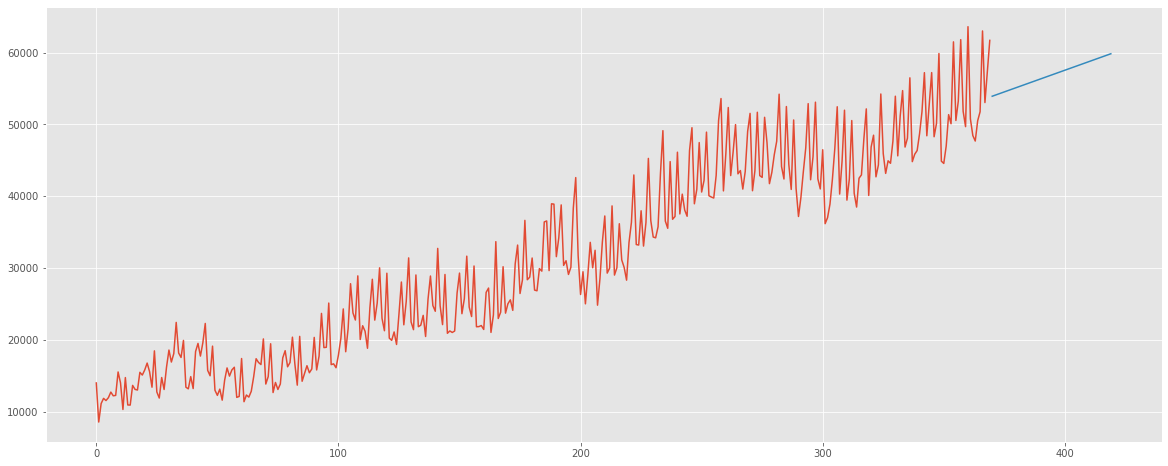

In [ ]:
# plt.plot(d2.TimeIndex, d2['Passengers_In'])
plt.plot(d2.TimeIndex[:-50], d2['Passengers_In'][:-50])

plt.plot(d2.TimeIndex[-50:], prediction)

Выделение тренда и сезонности

При работе с временными рядами выделяют два действия:

Дифференцирование - расчет разницы с определенным временным лагом
Декомпозиция - моделирование как тренда, так и сезонности и удаление их из модели.



Предположим, что у вас имеются ежемесячные данные о пассажиропотоке на международных авиалиниях.  
Объем пассажиропотока имеет во времени возрастающий линейный тренд, и в ряде имеется ежегодно повторяющаяся закономерность - сезонность (большинство перевозок приходится на летние месяцы, кроме того, имеется пик меньшей высоты в районе декабрьских каникул). 
Цель декомпозиции как раз и состоит в том, чтобы отделить эти компоненты, то есть разложить ряд на составляющую тренда, сезонную компоненту и оставшуюся нерегулярную составляющую. 

То есть каждый уровень временного ряда формируется под воздействием большого числа факторов, которые условно можно подразделить на три группы:
- факторы, формирующие тенденцию ряда
- факторы, формирующие циклические колебания ряда
- случайные факторы  

Рассмотрим воздействие каждого фактора на временной ряд в отдельности.  
Большинство временных рядов экономических показателей имеют тенденцию, 
характеризующую совокупное долговременное воздействие множества факторов на динамику изучаемого показателя.  
Все эти факторы, взятые в отдельности, могут оказывать разнонаправленное воздействие на исследуемый показатель. Однако в совокупности они формируют его возрастающую или убывающую тенденцию

В большинстве случаев фактический уровень временного ряда можно представить как сумму или произведение трендовой, циклической и случайной компонент. Модель, в которой временной ряд представлен как сумма перечисленных компонент, называется **аддитивной** моделью временного ряда. Модель, в которой временной ряд представлен как произведение перечисленных компонент, называется **мультипликативной** моделью временного ряда. 

In [ ]:
# отличие мультипликативной модели от аддитивной состоит в том, что в мультипликативной модели сезонная и случайная составляющие определены в виде относительных величин (коэффициентов), а в аддитивной модели – в виде абсолютных величин.
# Эти модели в практических расчетах дадут близкие результаты, если амплитуда колебаний уровней ряда слабо изменяется во времени


In [ ]:
# Декомпозиция
# Декомпозируем наш временной ряд на тренд и сезонность

In [1]:
from statsmodels.tsa.seasonal import seasonal_decompose
d2.index = d2.Date
d2.head()

NameError: ignored

In [ ]:

decomposition = seasonal_decompose(d2.Passengers_In, model = "additive")

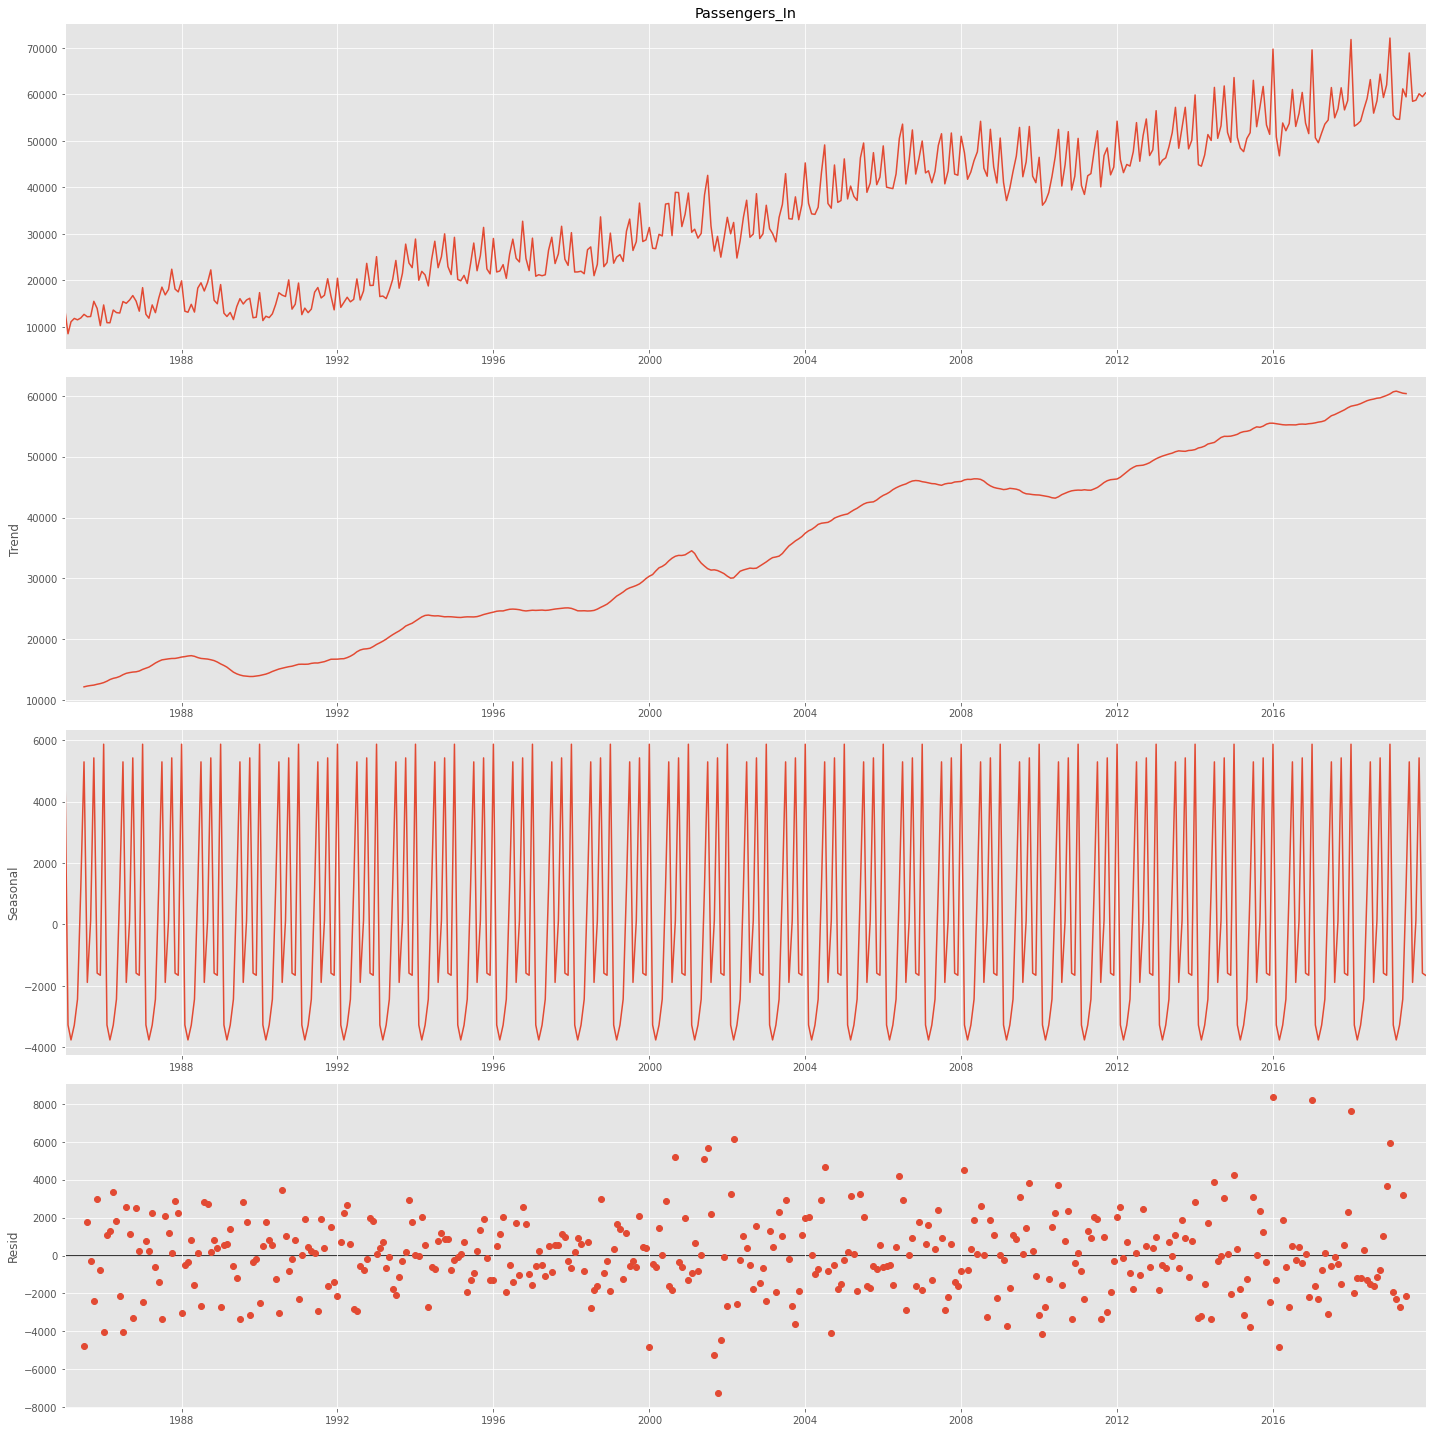

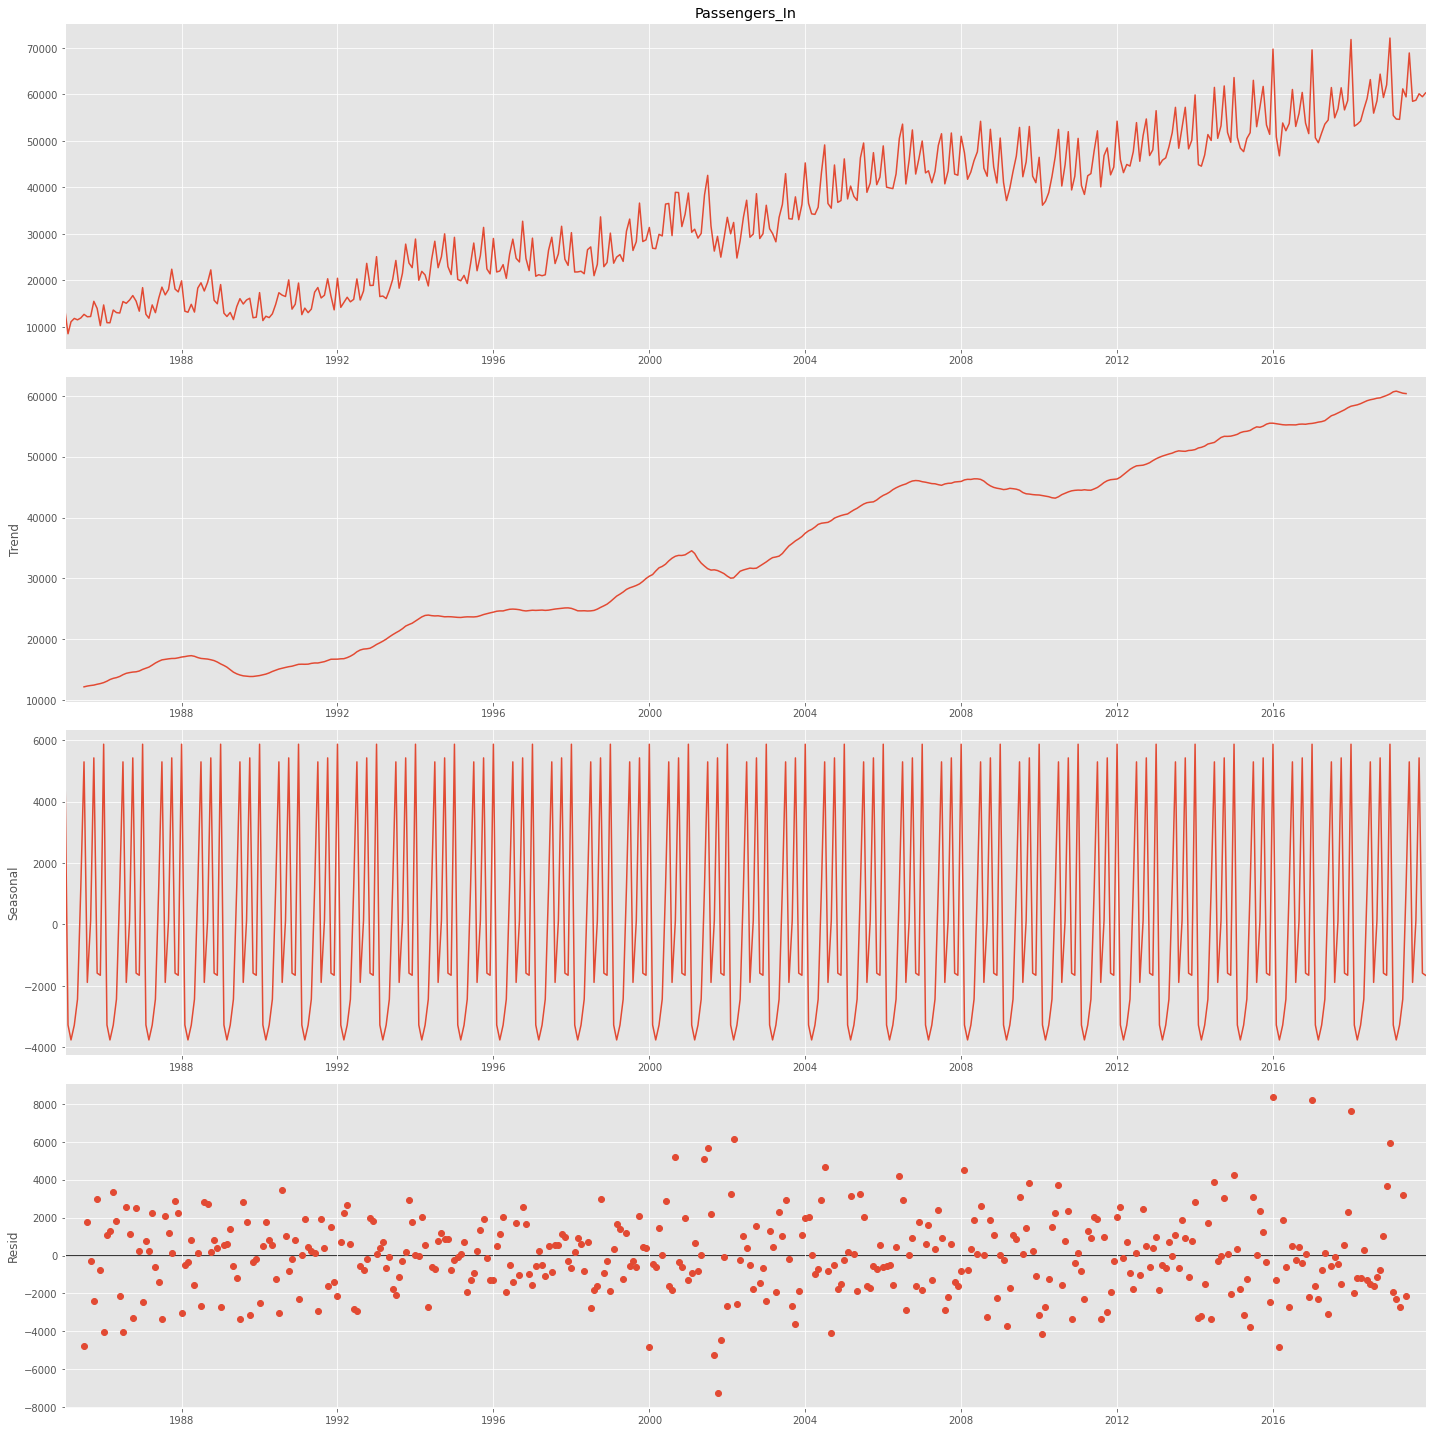

In [ ]:
plt.rcParams['figure.figsize'] = (20, 20)

decomposition.plot()

In [ ]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [ ]:
# Построим ряд по тренду и сезонности
d2["Passengers_In_Decomp"] = trend + seasonal


In [ ]:
# Расчет RMSE
model_Decomp_RMSE = RMSE(d2.Passengers_In_Decomp, d2.Passengers_In)
model_Decomp_RMSE

2084.60049650866

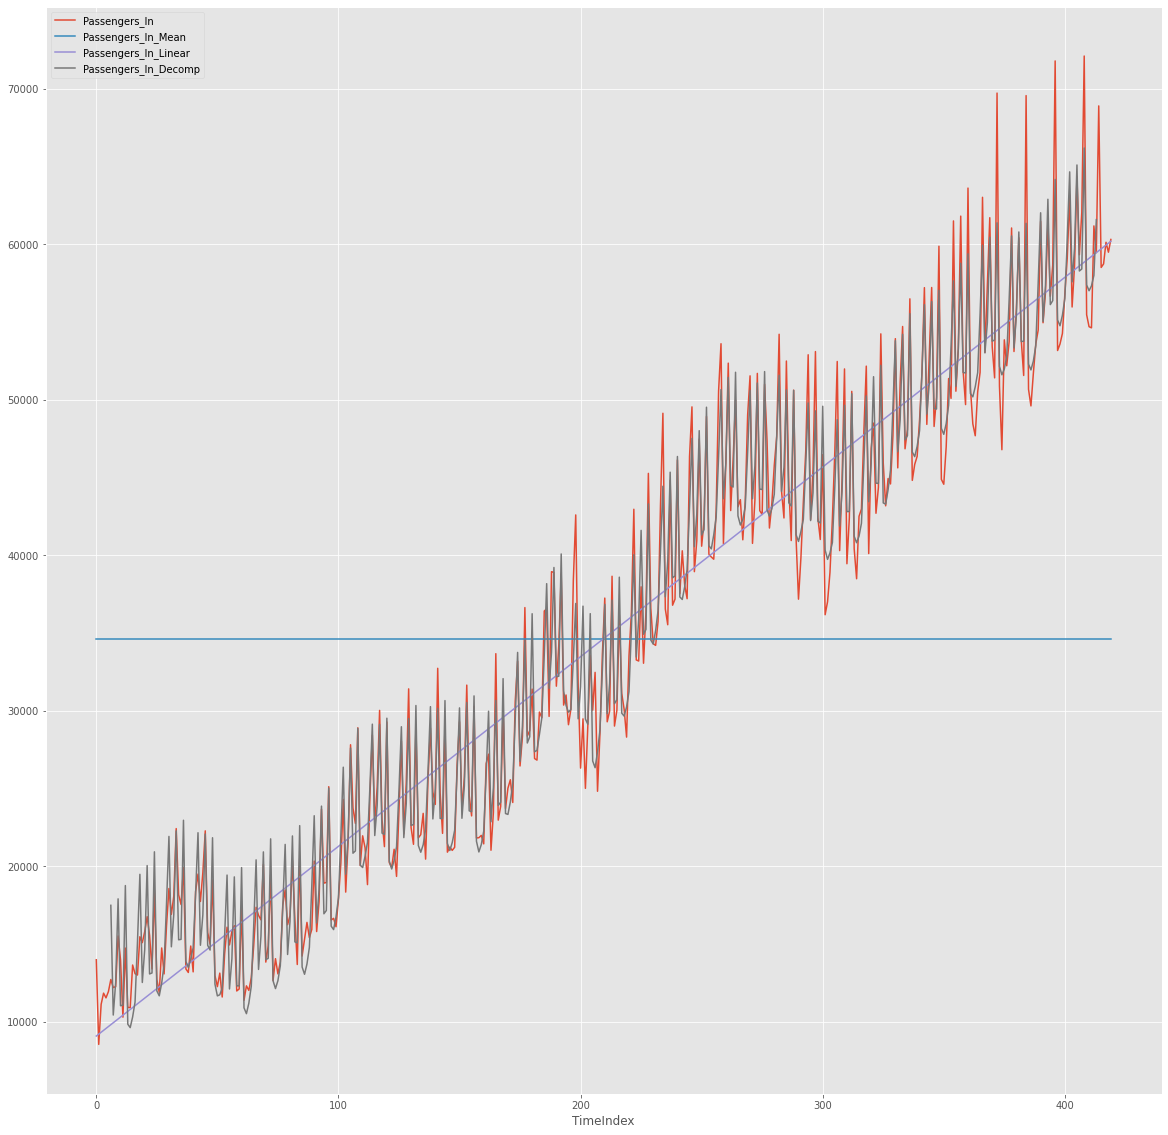

In [ ]:
d2.plot(kind="line", x="TimeIndex", y = ["Passengers_In", "Passengers_In_Mean",  'Passengers_In_Linear', "Passengers_In_Decomp"])

In [ ]:
d2Results

,Model,RMSE
0,Mean,15492.45


In [ ]:
d2Results.loc[3,"Model"] = "Passengers_In_Decomp"
d2Results.loc[3,"RMSE"] = model_Decomp_RMSE
d2Results.head()

,Model,RMSE
0,Mean,15492.45
3,Passengers_In_Decomp,2084.60
